In [1]:
library(rstac)
library(gdalcubes)
library(stars)
library(tmap)
gdalcubes::gdalcubes_options(parallel = TRUE)


Loading required package: abind

Loading required package: sf

Linking to GEOS 3.12.0, GDAL 3.7.1, PROJ 9.2.1; sf_use_s2() is TRUE

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)



In [2]:

## STAC Search over 400 million assets.
box <- c(xmin=-122.51006, ymin=37.70801, xmax=-122.36268, ymax=37.80668) 
start_date <- "2022-06-01"
end_date <- "2022-08-01"
items <- 
  stac("https://earth-search.aws.element84.com/v0/") |>
  stac_search(collections = "sentinel-s2-l2a-cogs",
              bbox = box,
              datetime = paste(start_date, end_date, sep="/"),
              limit = 100) |>
  post_request() 




In [3]:

col <-
  stac_image_collection(items$features,
                        asset_names = c("B04","B08", "SCL"),
                        property_filter = \(x) {x[["eo:cloud_cover"]] < 20})

cube <- cube_view(srs = "EPSG:4326",  
                  extent = list(t0 = start_date, t1 = end_date,
                                left = box[1], right = box[3],
                                top = box[4], bottom = box[2]),
                  nx = 2400, ny = 2400, dt = "P1D",
                  aggregation = "median", resampling = "average")

S2.mask <- image_mask("SCL", values=c(3,8,9)) # mask clouds and cloud shadows


Warning message in stac_image_collection(items$features, asset_names = c("B04", :
“STAC asset with name 'SCL' does not include eo:bands metadata and will be considered as a single band source”


In [4]:

ndvi <- raster_cube(col, cube, mask = S2.mask) |>
  select_bands(c("B04", "B08")) |>
  apply_pixel("(B08-B04)/(B08+B04)", "NDVI") |>
  reduce_time(c("mean(NDVI)")) |>
  st_as_stars()



stars object downsampled to 1000 by 1000 cells. See tm_shape manual (argument raster.downsample)



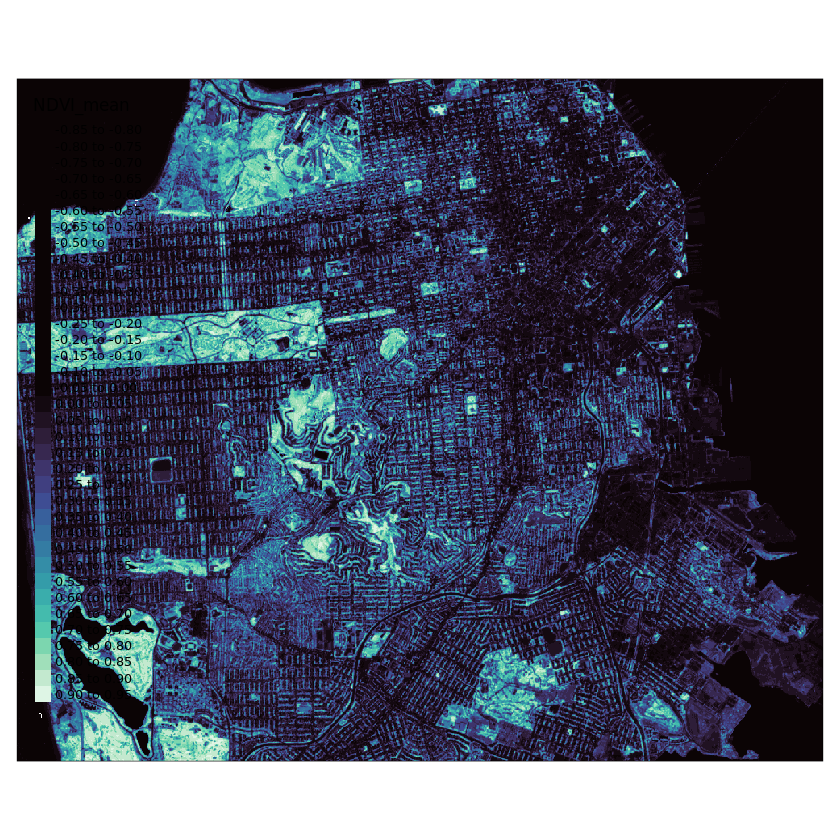

In [5]:
tm_shape(ndvi) + tm_raster(palette = viridisLite::mako(30), n = 30)